![](https://cocalc.com/blobs/paste-0.05592430265117643?uuid=f0881709-ebf0-4ee4-ab45-cc6dc07f668f)

**Rayleigh-Bénard convection with a stochastic boundary condition**

This notebook applies the forward Kolmogorov equation and domain partitioning to Rayleigh-Bénard convection with a stochastic boundary condition prescribed by an Ornstein–Uhlenbeck process. The Boussinesq equations are solved using the pseudo-spectral solver Dedalus ([Burns et al., 2020](https://doi.org/10.1103/PhysRevResearch.2.023068)), while the relevant terms in the zonal and global forward Kolmogorov equation are estimated using histograms.

First let's import everything we need to run the rest of the notebook.

In [ ]:
import numpy as np
import h5py
import json

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex's, preamble=r'\usepackage{amsfonts}')

**Problem Equations**

The Boussinesq equations are given by
\begin{equation}
    \begin{split}
    \frac{d \boldsymbol{U}_{t}}{dt}&=-\boldsymbol{U}_{t}\cdot\nabla \boldsymbol{U}_{t}+\alpha_{1}\Delta \boldsymbol{U}_{t} + B_{t}\boldsymbol{e}_{3}-\nabla P_{t},\\
    \nabla\cdot\boldsymbol{U}_{t}&=0, \\
    \frac{d B_{t}}{dt}&=-\boldsymbol{U}_{t}\cdot\nabla {B}_{t} + \alpha_{2}\Delta B_{t},
    \end{split}
\end{equation}
and are solved in a domain which is spatially periodic in $X^1 \in [0,4)$ and of unit height in the vertical $X^3 \in [0,1]$ with spatially-uniform buoyancy imposed on the top boundary 
\begin{equation}
    B_t = -1/2, \quad \text{at} \quad X^3 = 1,\\
\end{equation}
while on the bottom boundary the imposed buoyancy is spatially uniform of mean $\mu=1/2$ and follows an Ornstein-Uhlenbeck process in time such that
\begin{equation}
 dB_t = a (\mu - B_t) dt + \sigma dW_t, \quad \text{at} \quad X^3 = 0,\\
\end{equation}
where $a = 1/2,\sigma = 1$ are drift and diffusion coefficients respectively and $W_t$ a Wiener process (not to be cofused with the vertical velocity). In terms of these scales, the Rayleigh number which we set to $10^7$ corresponds to a (non-dimensionalised) viscosity and diffusivity of $\alpha_1 = \alpha_2 = \sqrt{10^7}$, for a Prandtl number of unity.

**DNS data/simulation**

Starting from a random initial condition we then use the solver for the Boussinesq equations contained in $\texttt{main.py}$ to generate a time-series of:

- snapshots of the buoyancy $B_t$, velocity $\boldsymbol{U}_t$, buoyancy gradient $\nabla B_t$ and the velocity gradient $\nabla \boldsymbol{U}_t$ as fields
- horizontally integrated buoyancy-flux W_tB_t and buoyancy gradient $\nabla B_t$ as well as their respective vertical gradients

sampled every $t_s = 2$ and $t_s \approxeq 1/5$ time-units respectively. 

Due to the demands of the simulations presented in the paper exceeding the resources available on Cocalc we load the data rather than running this script directly in the notebook. Nevertheless we also provide the script $\texttt{main.py}$ which includes instructions on how to generate this data should one wish to do so on their local machine. 

In [2]:
# Loading the data
fname_timeseries = './paper_data_subsampled/timeseries/timeseries_s1.h5'
fname_fields = './paper_data_subsampled/fields/fields_s1.h5'
params_fname = './paper_data_subsampled/parameters.json'

Having loaded/generated the data we check the volume-averaged buoyancy flux $\mathbb{E}[W_t B_t]$ to verify that a statistically stationary regime has been reached.

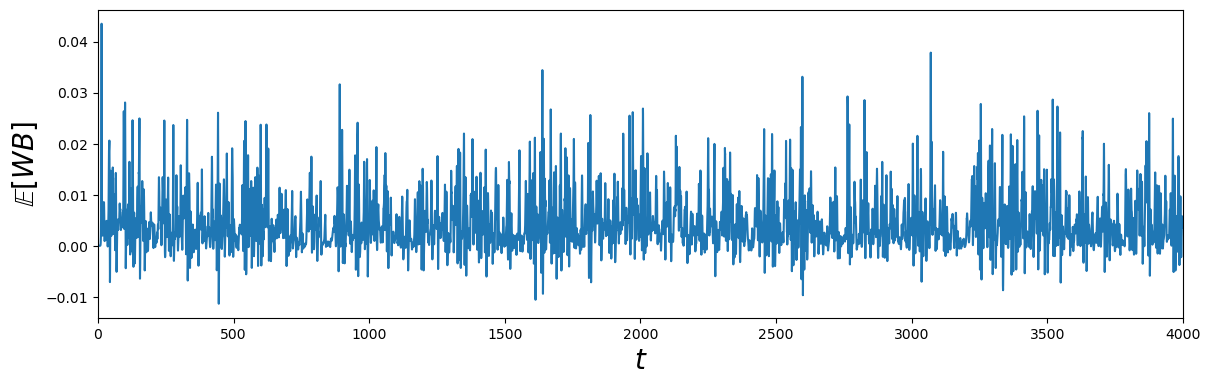

In [ ]:
with open(params_fname) as f:
    params = json.load(f)

with h5py.File(fname_timeseries, mode='r') as file:
    t = file['tasks']['<wb>'].dims[0]['sim_time'][:]
    WB = file['tasks']['<wb>'][:].squeeze()

# Check volume-averaged buoyancy flux
plt.figure(figsize=(14, 4))
plt.plot(t,WB)
plt.xlabel(r'$t$',fontsize=20)
plt.ylabel(r'$\mathbb{E}[WB]$',fontsize=20)
plt.xlim([0,4000])
plt.show()
plt.close('all')

**Partitions and mixture distributions**

Using the data snapshots generated by the Boussinesq equations we define: 

\begin{equation}
  f_{X}(x)=\sum_{z\in\mathbb{Z}}f_{X|Z}(x|z)\mathbb{P}\{Z=z\},
\end{equation}

where $\mathbb{P}\{Z=z\}$ is the proportion of the original control volume attributed to zone $z$. Here we partition the vertical domain into three zones $Z\in\{z_1,z_2,z_3\}$ defined by $f_{X|Z}$, as such $X$ is a scalar and corresponds to the vertical coordinate $X^3$. 

In the boundary-layer zone above the bottom boundary $f_{X|Z}$ is proportional to the horizontally-and time-averaged diffusive heat flux $-\alpha_{2}\partial_{X^{3}}B_t(\boldsymbol{X})$ and is given by

\begin{equation}
f_{X|Z}(x|z_1) = 
\begin{cases} 
\frac{1}{N} \frac{1}{T - t_0} \int_{t_0}^T \left( \frac{1}{L_x} \int_0^{L_x} - \alpha_2 \partial_{X^{3}}B_t \, dX^1 \right) \, dt,& \quad \text{for} \quad X^3 < 1/2, \\
0,& \quad \text{for} \quad X^3 > 1/2,
\end{cases}
\end{equation}

The central zone $f_{X|Z}(x|z_2)$ is proportional to the horizontally-and time-averaged vertical buoyancy flux $W_t(\boldsymbol{X})B_t(\boldsymbol{X})$ and is given by

\begin{equation}
f_{X|Z}(x|z_2) = \frac{1}{N} \frac{1}{T - t_0} \int_{t_0}^T \left( \frac{1}{L_x} \int_0^{L_x} W_t B_t \, dX^1 \right) \, dt,
\end{equation}

In the boundary-layer zone below the top boundary $f_{X|Z}$ is again proportional to the horizontally-and time-averaged diffusive heat flux $-\alpha_{2}\partial_{X^{3}}B_t(\boldsymbol{X})$ and is given by

\begin{equation}
f_{X|Z}(x|z_3) = 
\begin{cases} 
0,& \quad \text{for} \quad X^3 < 1/2, \\
\frac{1}{N} \frac{1}{T - t_0} \int_{t_0}^T \left( \frac{1}{L_x} \int_0^{L_x} - \alpha_2 \partial_{X^{3}}B_t \, dX^1 \right) \, dt,& \quad \text{for} \quad X^3 > 1/2, \\
\end{cases}
\end{equation}


The normalisation constant $\mathbb{P}\{Z=z\} = 1/N$ is determined such that

\begin{equation}
  \int f_{X}(x) \, dx = \int \sum_{z\in\mathbb{Z}}f_{X|Z}(x|z)\mathbb{P}\{Z=z\} \, dx = 1,
\end{equation}

When constructing these distributions we choose a $t_0 > 0$ in order to discard transients retained from the initial conditions.

In [4]:
from helper import time_average

# Define transient period to discard
t0 = 100

# Create empty set of sample distributions for internal and boundary points
f_Xs = [None]*3

# (a) Get 1d profiles to define f_X 
with h5py.File(fname_timeseries, mode='r') as file:
    t = file['tasks']['<wb>(z)'].dims[0]['sim_time'][:]
    z_1d = file['tasks']['<wb>(z)'].dims[2][0][:]
    
    # Unnormalised sample distributions based on buoyancy flux

    # Bottom zone
    f_Xs[0] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t, t0) 

    # Central zone
    f_Xs[1] =  time_average( file['tasks']['<wb>(z)'][:], t, t0)

    # top zone
    f_Xs[2] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t, t0)  

# (b) Split the diffusive buoyancy flux between the bottom and top boundary layer
f_Xs[0][ z_1d>params['Lz']/2 ] = 0 # Bottom half of the domain
f_Xs[2][ z_1d<params['Lz']/2 ] = 0 # Top half of the domain

# (c) Defined normalisation constant and normalise the sample distributions
N = np.trapezoid(f_Xs[0]+f_Xs[1]+f_Xs[2], x=z_1d)

f_Xs[0] = f_Xs[0]/N
f_Xs[1] = f_Xs[1]/N
f_Xs[2] = f_Xs[2]/N

Having determined the normalised distributions we then plot out the buoyancy field $B_t(\boldsymbol{X})$ with contours of the vertical velocity $W_t(\boldsymbol{X})$ superimposed alongside $f_X$ and $f_{X|Z}$.

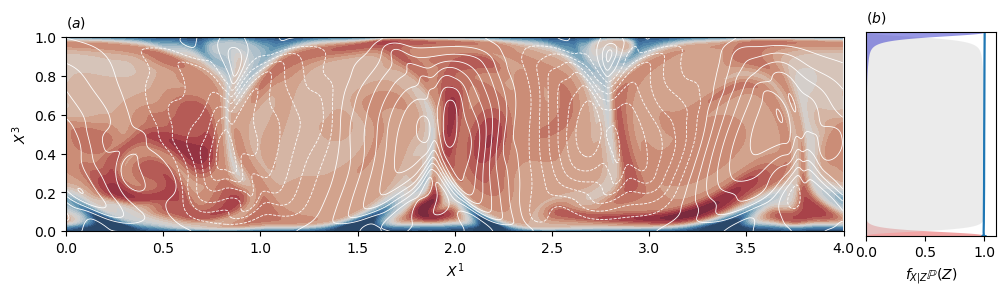

In [ ]:
fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[6,1],'wspace':0.05,'bottom':0.2},figsize=(12,3))

# Get boundary information from the wall slices  
with h5py.File(fname_fields, mode='r') as file:
    t = file['tasks']['B'].dims[0][0][:]
    X = file['tasks']['B'].dims[1][0][:]
    Z = file['tasks']['B'].dims[2][0][:] # Chebyshev

    # Pick an index for the snapshot (after negative fluctuation in buoyancy at the bottom boundary)
    idx = np.where(t>t0)[0][66]

    B = file['tasks']['B'][idx,:,:]
    W = file['tasks']['W'][idx,:,:]

# Plot field
ax[0].contourf(X, Z, B[:,:].T, np.linspace(-0.5, 0.5, 21), cmap='RdBu_r', extend='both')
ax[0].set_aspect('equal', adjustable='box')
ax[0].contourf(X, Z, 0*B[:,:].T, [0,1e5], cmap='gray', alpha=0.3)
ax[0].contour(X, Z, W[:,:].T,np.linspace(-1,1,21), colors='w',linewidths=0.6)
ax[0].set_xlabel(r'$X^{1}$')
ax[0].set_ylabel(r'$X^{3}$')
ax[0].set_xlim([0,params['Lx']])
ax[0].set_ylim([0,params['Lz']])
ax[0].annotate(r'$(a)$', xy=(0.0, 1.05), xycoords='axes fraction')


# Plot boundary layer and bulk zones
col = (0.85,0.85,0.85) # Define grey color
ax[1].fill_betweenx(z_1d, f_Xs[0], color=(0.9,0.3,0.3), alpha=0.5, edgecolor=None)
ax[1].fill_betweenx(z_1d, f_Xs[1], color=(0.85,0.85,0.85), alpha=0.5, edgecolor=None)
ax[1].fill_betweenx(z_1d, f_Xs[2], color=(0.2,0.2,0.8), alpha=0.5, edgecolor=None)
ax[1].plot((f_Xs[0]+f_Xs[1]+f_Xs[2]), z_1d, '-C0', lw=1.6)
ax[1].set_xlabel(r'$f_{X|Z}\mathbb{P}(Z)$')
ax[1].set_yticks([])
ax[1].set_ylim([0,1])
ax[1].set_xlim([0,1.1])
ax[1].annotate(r'$(b)$', xy=(0.0, 1.05), xycoords='axes fraction')

plt.savefig('fig_field.pdf',dpi=100)
plt.show()
plt.close('all')

**Forward Kolmogorov equation for the zonal distribution $f_{\boldsymbol{Y}|Z}$**

Having determined $f_X$ and $f_{X|Z}$ we now illustrate how the partition yields useful information, to do so we focus on the contributions to the equations governing $f_{\boldsymbol{Y}|Z}$ from $V$ and $\mathbf{D}_1$ due to transport between the zones. 

*(a) Kolmogorov equation for $f_{\boldsymbol{Y}}$*

The forward Kolmogorov equation for $f_{\boldsymbol{Y}}$ where $\boldsymbol{Y}_t = (W_t, B_t)$ is given by

\begin{equation}
\frac{\partial }{ \partial t} f_{\boldsymbol{Y}} =  - V f_{\boldsymbol{Y}} -\frac{\partial}{ \partial y_i} \left( \mathbf{D}^i_1 f_{\boldsymbol{Y}} \right) + \frac{\partial^2 }{ \partial y_i \partial y_j} \left( \mathbf{D}^{ij}_2 f_{\boldsymbol{Y}} \right),
\end{equation}
where as the sources and fluxes obtained from the Boussinesq equations are given by
\begin{equation}
\boldsymbol{I}_t = (B_t - \partial_{X^3} P_{t}, 0), \quad\quad \boldsymbol{J}_t = (W_t \boldsymbol{U}_t -\alpha_{1}\nabla W_{t}, B_t \boldsymbol{U}_t -\alpha_{2}\nabla B_{t})
\end{equation} 
we obtain (following section 3 of the manuscript) that from the advective component of $\boldsymbol{J}_t$ that
\begin{equation}
V := -\mathbb{E}[ \boldsymbol{U}_t \cdot \nabla \log f_{\boldsymbol{X}} | \boldsymbol{Y}_t = \boldsymbol{y} ] = -\mathbb{E}[ W_t \partial_X \log f_X | \boldsymbol{Y}_t = \boldsymbol{y} ],
\end{equation}
where the simplification follows from the fact that $X^1$ is periodic. Similarly following section 3.3 of the manuscript we obtain from the diffusive component of $\boldsymbol{J}_t$ and the sources $\boldsymbol{I}_t$ that
\begin{equation}
    \mathbf{D}_{1} :=
    \begin{pmatrix}
     \mathbb{E}[B_t - \partial_{X^3} P_{t} | \boldsymbol{Y}_t = \boldsymbol{y} ] \\
    0 
    \end{pmatrix}
    + \mathbb{E} \left[
    \begin{matrix}
        -\alpha_{1}\nabla W_{t}\cdot\nabla \log f_{\boldsymbol{X}}\\
        -\alpha_{2}\nabla B_{t}\cdot\nabla \log f_{\boldsymbol{X}} 
    \end{matrix}
    \Bigg| \boldsymbol{Y}_t = \boldsymbol{y}
    \right]
\end{equation} 
where the latter term can again be simplified as per $V$ as $X^1$ is periodic. As we are only concerned with the role of terms $V$ and $\mathbf{D}_1$ we do not state $\mathbf{D}_2$.

-------


*(b) Kolmogorov equation for $f_{\boldsymbol{Y}|Z}$*

Having obtained an equation for $f_{\boldsymbol{Y}}$ we now substitute for 
\begin{equation}
  f_{X}(x)=\sum_{z\in\mathbb{Z}}f_{X|Z}(x|z)\mathbb{P}\{Z=z\}, \quad\quad f_{\boldsymbol{Y}}(\boldsymbol{y})=\sum_{z\in\mathbb{Z}}f_{\boldsymbol{Y}|Z}(x|z)\mathbb{P}\{Z=z\},
\end{equation}
and gather terms propotional to $f_{X|Z}$ and $f_{\boldsymbol{Y}|Z}$ to obtain an equation for the forward Kolmogorov equation for the zonal distribution $f_{\boldsymbol{Y}|Z}$ as given by 

\begin{equation}
\frac{\partial }{ \partial t} f_{\boldsymbol{Y}|Z} =  - V f_{\boldsymbol{Y}|Z} -\frac{\partial}{ \partial y_i} \left( \mathbf{D}^i_1 f_{\boldsymbol{Y}|Z} \right) + \frac{\partial^2 }{ \partial y_i \partial y_j} \left( \mathbf{D}^{ij}_2 f_{\boldsymbol{Y}|Z} \right),
\end{equation}
where
\begin{equation}
V := -\mathbb{E}[ W_t \partial_X \log f_{X|Z} | \boldsymbol{Y}_t = \boldsymbol{y}, Z = z],
\end{equation}
and
\begin{equation}
    \mathbf{D}_{1} :=
    \begin{pmatrix}
    \mathbb{E}[B_t - \partial_{X^3} P_{t} | \boldsymbol{Y}_t = \boldsymbol{y}, Z = z ] \\
    0
    \end{pmatrix}
    + \mathbb{E}\left[
    \begin{matrix}
        -\alpha_{1} \left( \partial_{X^3} W_{t} \right) \left( \partial_X \log f_{X|Z} \right)\\
        -\alpha_{2} \left( \partial_{X^3} B_{t} \right) \left( \partial_X \log f_{X|Z} \right)
    \end{matrix}\,\middle|\, \boldsymbol{Y}_t = \boldsymbol{y}, Z = z
\right],
\end{equation} 
where we have used the fact that $X^1$ is periodic in writing $\mathbf{D}_1$.

-------


*(c) Kolmogorov equation for $f_{B|Z}$*

As we are also interested in obtaining an equation for the evolution of the marginal zonal distribution $f_{B|Z}$ we integrate the Kolmogorov equation for $f_{\boldsymbol{Y}|Z}$ with respect to $w$ to obtain

\begin{equation}
\frac{\partial }{ \partial t} f_{B|Z} =  -\mathbb{E}[V | B_t = b, Z = z ] f_{B|Z} -\frac{\partial}{ \partial b} \left( \mathbb{E}[\mathbf{D}_1^1 | B_t = b, Z = z ] f_{B|Z} \right) + \frac{\partial^2 }{ \partial b^2} \left( \mathbb{E}[\mathbf{D}_2^{11} | B_t =b, Z = z ] f_{B|Z} \right),
\end{equation}

Using the data loaded above we now construct $f_{\boldsymbol{Y}|Z}$ and the terms in the Kolmogorov equation for $f_{\boldsymbol{Y}|Z}$ using histograms, from which we can then obtained the terms in the Kolmogorov equation for the marginal distributions. 

**Calculating $f_{\boldsymbol{Y}|Z}$ and the terms $V$ and $\mathbf{D}_1$**

We first re-determine the un-normalised $f_{X|Z}$ and its gradient $\partial_X f_{X|Z}$. The gradient term will be used to compute expectations containing terms $\partial_X \log f_{X|Z}$ because this can be expressed as $\partial_X \log f_{X|Z} = \frac{\partial_X  f_{X|Z}}{f_{X|Z}}$. 

Below we denote $f_{X|Z}$ by $\texttt{fXs}$ and $\partial_X f_{X|Z}$ by $\texttt{dfXs}$.

In [6]:
from helper import time_average

# Create empty set of sample distributions for internal and boundary points
f_Xs = [None]*3
df_Xs = [None]*3

# (a) Get 1d profiles to define f_X, df_X 
with h5py.File(fname_timeseries, mode='r') as file:
    t_ = file['tasks']['<wb>(z)'].dims[0]['sim_time'][:]
    z_1d = file['tasks']['<wb>(z)'].dims[2][0][:]
    
    # Unnormalised sample distributions based on buoyancy flux

    # Bottom zone
    f_Xs[0] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t_, t0) 
    df_Xs[0] = -params['alpha_2']*time_average( file['tasks']['<ddb_dz2>(z)'][:], t_, t0)

    # Central zone
    f_Xs[1] =  time_average( file['tasks']['<wb>(z)'][:], t_, t0)
    df_Xs[1] = time_average(file['tasks']['<dwb_dz>(z)'][:], t_, t0)

    # top zone
    f_Xs[2] = -params['alpha_2']*time_average( file['tasks']['<db_dz>(z)'][:], t_, t0)  
    df_Xs[2] = -params['alpha_2']*time_average( file['tasks']['<ddb_dz2>(z)'][:], t_, t0)

# (b) Split the diffusive buoyancy flux between the bottom and top boundary layer
f_Xs[0][ z_1d>params['Lz']/2 ] = 0 # Bottom half of the domain
f_Xs[2][ z_1d<params['Lz']/2 ] = 0 # Top half of the domain

df_Xs[0][ z_1d>params['Lz']/2 ] = 0 # Bottom half of the domain
df_Xs[2][ z_1d<params['Lz']/2 ] = 0 # Top half of the domain

Having determined $f_{X|Z}$ and its gradient $\partial_X f_{X|Z}$ we now calculate $f_{\boldsymbol{Y}|Z}$. As the fields of loaded data use non-uniformally spaced Chebyshev-colocalation points in $X^3$ we must first interpolate them onto a uniformly spaced grid.


*Note: Due to the large amount of data being loaded into memory and then interpolated this step takes approximately 2 minutes to run. Increasing $\texttt{t0=100}$ reduces the amount of data being loaded but at the expense of poorer statistics.*

In [ ]:
from helper import interp, build_pdf

# Get boundary information from the wall slices  
with h5py.File(fname_fields, mode='r') as file:
    t = file['tasks']['B'].dims[0][0][:]
    X = file['tasks']['B'].dims[1][0][:]
    Z = file['tasks']['B'].dims[2][0][:] # Chebyshev

    idx = np.where(t>t0)[0][0]

    B = file['tasks']['B'][idx:,:,:]
    W = file['tasks']['W'][idx:,:,:]
    dBdZ = file['tasks']['dBdz'][idx:,:,:]
    dWdZ = file['tasks']['dWdz'][idx:,:,:]

# (a) Interpolate the fields B_t, W_t, grad(B_t), grad(W_t) on to a uniform grid in Z=X^3
Nz = 256
dz = 1/Nz
z = np.linspace(dz/2,1-dz/2,Nz)

# Define fields for constructing the PDF
Y1 = interp(W, Z, z, axis=2)
Y2 = interp(B, Z, z, axis=2)

grad_Y1 = interp(dWdZ, Z, z, axis=2)
grad_Y2 = interp(dBdZ, Z, z, axis=2)

To construct $f_{\boldsymbol{Y}|Z}$ we use the corresponding distribution $f_{X|Z}$ to weight $\boldsymbol{Y}_t = (W_t, B_t)$, the set of data interpolated onto a uniformly spaced grid from which $f_{\boldsymbol{Y}|Z}$ is constructed. When doing so we must also interpolate $f_{X|Z}$ onto a uniformly spaced grid.

In [8]:
# (a) Initialise a list of PDF objects and build the PDFs
Omega = [None]*3
dOmega = [None]*3

minmax = [(Y1.min(), Y1.max()), (Y2.min(), Y2.max())]
yrange = [minmax, [(-1,1),(-0.5,1.5)], minmax]

dx = (params['Lx']/B.shape[1], params['Lz']/B.shape[2])
for i in [0,1,2]:
    print('i = ',i)

    # Interpolate the (unnormalised) sample distributions to a uniform grid
    f_Xs_i  = interp(f_Xs[i] , z_1d, z, axis=0)
    df_Xs_i = interp(df_Xs[i], z_1d, z, axis=0)
    
    # Tile these distributions Nx times i.e. the number of grid points in the x-direction 
    # this creates a 2D array of weights of shape (Nx, Nz) with which to build the PDF 
    f_X  = np.tile(  f_Xs_i, (Y1.shape[1],1) )
    df_X = np.tile( df_Xs_i, (Y1.shape[1],1) )

    # Construct PDF object
    Omega[i] = build_pdf(Y1, Y2, f_X=f_X, df_X=df_X, dx=dx, range_=yrange[i])

i =  0
i =  1
i =  2


Having calculated $f_{\boldsymbol{Y}|Z}$ we then plot: 

- the marginal distributions for the bottom boundary layers in column 0 
- the joint distribution for the bulk in column 1
- the marginal distributions for the top boundary layers in column 2 

for each plot we also compute the coefficients $V$ and $\mathbf{D}_1$ by evaluating the boundary expectations.

In [9]:
V = [None]*3
D_1 = [None]*3

Then we determine the budget terms in the forward equation for the marginal $f_{B|Z}$ 

\begin{equation}
\frac{\partial }{ \partial t} f_{B|Z} =  -\mathbb{E}[V | B_t = b, Z = z ] f_{B|Z} -\frac{\partial}{ \partial b} \left( \mathbb{E}[\mathbf{D}_1^1 | B_t = b, Z = z ] f_{B|Z} \right) + \frac{\partial^2 }{ \partial b^2} \left( \mathbb{E}[\mathbf{D}_2^{11} | B_t =b, Z = z ] f_{B|Z} \right),
\end{equation}

for the bottom boundary layer $f_{X|Z}(x|z_{1})$.

In [10]:
# Bottom boundary layer
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
i = 0

# Calculate coefficients in the forward equation
D_1[i] =  Omega[i].E_Y2( Omega[i].E_Y(-params['alpha_2']*grad_Y2, boundary=True) )  # Determine D_1 in z_0
V[i]   = -Omega[i].E_Y2( Omega[i].E_Y(                        Y1, boundary=True) )  # Determine V in z_0

For the central zone we calculate the terms in forward Kolmogorov equation for the zonal distribution $f_{\boldsymbol{Y}|Z}$ as given by 
\begin{equation}
\frac{\partial }{ \partial t} f_{\boldsymbol{Y}|Z} =  - V f_{\boldsymbol{Y}|Z} -\frac{\partial}{ \partial y_i} \left( \mathbf{D}^i_1 f_{\boldsymbol{Y}|Z} \right) + \frac{\partial^2 }{ \partial y_i \partial y_j} \left( \mathbf{D}^{ij}_2 f_{\boldsymbol{Y}|Z} \right),
\end{equation}
where
\begin{equation}
V := -\mathbb{E}[ W_t \partial_X \log f_{X|Z} | \boldsymbol{Y}_t = \boldsymbol{y}, Z = z],
\end{equation}
and
\begin{equation}
    \mathbf{D}_{1} :=
    \begin{pmatrix}
    \mathbb{E}[B_t - \partial_{X^3} P_{t} | \boldsymbol{Y}_t = \boldsymbol{y}, Z = z ]  \\
    0
    \end{pmatrix}
    + \mathbb{E}\left[
    \begin{matrix}
        -\alpha_{1} \left( \partial_{X^3} W_{t} \right) \left( \partial_X \log f_{X|Z} \right)\\
        -\alpha_{2} \left( \partial_{X^3} B_{t} \right) \left( \partial_X \log f_{X|Z} \right)
    \end{matrix}\,\middle|\, \boldsymbol{Y}_t = \boldsymbol{y}, Z = z
\right],
\end{equation} 
with the exception of the contribution of the $\mathbb{E}_{\boldsymbol{Y}_t}[B_t - \partial_{X^3} P_{t} ]$ in $\mathbf{D}_1$. Accordingly $\mathbf{D}_1$ now contains two terms for the joint distribution.

In [11]:
# Central zone
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
i = 1 # bulk zone

# Calculate coefficients in the forward equation
D_1[i] = np.array([Omega[i].E_Y(-params['alpha_2']*grad_Y2, boundary=True), Omega[i].E_Y(-params['alpha_1']*grad_Y1, boundary=True)])  # Determine D_1 in z_1
V[i]   = -Omega[i].E_Y(Y1, boundary=True)  # Determine V in z_1

Finally we determine the budget terms in the forward equation for the marginal $f_{B|Z}$ 

\begin{equation}
\frac{\partial }{ \partial t} f_{B|Z} =  -\mathbb{E}[V | B_t = b, Z = z ] f_{B|Z} -\frac{\partial}{ \partial b} \left( \mathbb{E}[\mathbf{D}_1^1 | B_t = b, Z = z ] f_{B|Z} \right) + \frac{\partial^2 }{ \partial b^2} \left( \mathbb{E}[\mathbf{D}_2^{11} | B_t =b, Z = z ] f_{B|Z} \right),
\end{equation}

for the top boundary layer $f_{X|Z}(x|z_{3})$.

In [12]:
# Top boundary layer
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
i = 2

# Calculate coefficients in the forward equation
D_1[i] =  Omega[i].E_Y2( Omega[i].E_Y(-params['alpha_2']*grad_Y2, boundary=True) )  # Determine D_1 in z_2
V[i]   = -Omega[i].E_Y2( Omega[i].E_Y(                        Y1, boundary=True) )  # Determine V in z_2

/home/pmannix/Theory/Rayleigh-Benard/helper.py:126: RuntimeWarning: invalid value encountered in divide
  return np.sum(self.f_Y*g_Y, axis=0)/self.f_Y2() * self.dy[0]


Below we plot the marginal distributions, the joint distributions and the budget terms. 

In [ ]:

# (c) Set up a figure for plotting the marginal distributions and budget terms

# Limits for the plots
y1lim = [-0.16,0.16]
y2lim = [[-1.5,2.5],[-0.5,0.5],[-0.7,0.7]]
xlim_top = [[-1/3,1],[-1,3],[-1,1]]
xlim_bot = [[-1/3,1],[-1,3],[-3.2,3.2]]

fig, ax = plt.subplots(1,3,gridspec_kw={'width_ratios':[1,1.2,1],'wspace':0.3,'bottom':0.2},figsize=(2*8,2*3.5))
labs = [r'$(a)$',r'$(b)$',r'$(c)$']


# Bottom boundary layer
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
i = 0

# Plot the marginal distribution for the bottom boundary layer
ax[i].barh(Omega[i].y2, Omega[i].f_Y2(),color='darkred',alpha=0.8,height=Omega[i].dy[1])  # Plot f_B|Z(b|z_0)
ax[i].set_xlabel(r'$f_{B|Z=z_1}$')
ax[i].set_ylim(y2lim[i])
ax[i].set_xlim(xlim_bot[i])
ax[i].set_ylabel('$b$')


# Plot the budget terms for the bottom boundary layer
ax2 = ax[i].twiny()
ax2.fill_betweenx(Omega[i].y2,-V[i] * Omega[i].f_Y2(), color=col, alpha=0.6,lw=0)
ax2.plot(-V[i] * Omega[i].f_Y2(), Omega[i].y2, '-k', lw=0.6)
ax2.plot(-np.gradient(D_1[i] * Omega[i].f_Y2(),Omega[i].y2), Omega[i].y2,'-',color='navy',lw=0.8)
ax2.set_xlabel(r'$\partial_{t} f_{B|Z=z_1}$')
ax2.set_xlim(xlim_top[i])
ax2.plot([0,0],y2lim[i],'-k',lw=0.6)
ax2.plot(xlim_top[i],[y2lim[1][0]]*2,'-k',lw=0.6)
ax2.plot(xlim_top[i],[y2lim[1][1]]*2,'-k',lw=0.6)
ax[i].annotate(labs[i], xy=(0.0, 1.1), xycoords='axes fraction')


# Central zone
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
i = 1 # bulk zone

c = 0.1 # Constant for positive and negative forcing zones

# Plot the joint distribution in z_1
ax[i].contourf(Omega[i].y1_2d, Omega[i].y2_2d,        Omega[i].f_Y, cmap='pink_r')

# Plot the V terms in the forward equation
ax[i].contourf(Omega[i].y1_2d, Omega[i].y2_2d,     -V[i]*Omega[i].f_Y, [c,np.inf], colors='k',alpha=0.2)
ax[i].contourf(Omega[i].y1_2d, Omega[i].y2_2d,     -V[i]*Omega[i].f_Y, [-np.inf, -c], colors='w',alpha=0.5)
ax[i].contour( Omega[i].y1_2d, Omega[i].y2_2d,     -V[i]*Omega[i].f_Y, [c], colors='k', linestyles='solid', linewidths=0.4)
ax[i].contour( Omega[i].y1_2d, Omega[i].y2_2d,     -V[i]*Omega[i].f_Y, [-c], colors='k', linestyles='solid', linewidths=0.4)

# Plot the D_1 terms in the forward equation
ax[i].quiver(  Omega[i].y1_2d, Omega[i].y2_2d, D_1[i][1]*Omega[i].f_Y, D_1[i][0]*Omega[i].f_Y, angles='xy', scale_units='xy', scale=0.7, width=2e-3,color='navy',headwidth=4)

ax[i].annotate(r'$\underline{\uparrow}$', (0.05,0.4))
ax[i].annotate(r'$\underline{\downarrow}$', (-0.08,0.2))
ax[i].annotate(r'$\overline{\uparrow}$', (0.1,0.14))
ax[i].annotate(r'$\overline{\downarrow}$', (-0.09,-0.4))

ax[i].set_xlim(y1lim)
ax[i].set_xlabel(r'$w$')
ax[i].set_ylim(y2lim[i])
ax[i].annotate(labs[i], xy=(0.0, 1.1), xycoords='axes fraction')


# Top boundary layer
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
i = 2

# Plot the marginal distribution for the top boundary layer
ax[i].barh(Omega[i].y2, Omega[i].f_Y2(),color='darkred',alpha=0.8,height=Omega[i].dy[1])
ax[i].set_xlabel(r'$f_{B|Z=z_3}$')
ax[i].set_ylim(y2lim[i])
ax[i].set_xlim(xlim_bot[i])

# Plot the budget terms for the top boundary layer
ax2 = ax[i].twiny()
ax2.fill_betweenx(Omega[i].y2,-V[i] * Omega[i].f_Y2(), color=col, alpha=0.6,lw=0)
ax2.plot(-V[i] * Omega[i].f_Y2(), Omega[i].y2, '-k', lw=0.6)
ax2.plot(-np.gradient(D_1[i] * Omega[i].f_Y2(),Omega[i].y2), Omega[i].y2,'-',color='navy',lw=0.8)
ax2.set_xlabel(r'$\partial_{t} f_{B|Z=z_3}$')
ax2.set_xlim(xlim_top[i])
ax2.plot([0,0],y2lim[i],'-k',lw=0.6)
ax2.plot(xlim_top[i],[y2lim[1][0]]*2,'-k',lw=0.6)
ax2.plot(xlim_top[i],[y2lim[1][1]]*2,'-k',lw=0.6)
ax[i].annotate(labs[i], xy=(0.0, 1.1), xycoords='axes fraction')


plt.savefig('fig_joint.pdf',dpi=100)

plt.show()